https://github.com/pinecone-io/examples/tree/master/learn/generation/better-rag

In [1]:
from semantic_router.encoders import OpenAIEncoder
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger
import os

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

encoder = OpenAIEncoder(name="text-embedding-3-large", openai_api_key=OPENAI_API_KEY)



logger.setLevel("WARNING")  # reduce logs from splitter

splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=100,
    max_split_tokens=500,
    window_size=2,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

/Users/brandon/anaconda3/envs/chroma-research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/3j/gh2y6ksd25d576rdjgmpgdc80000gn/T/ipykernel_55821/3710908105.py:13: UserWarning: Splitters are being deprecated. They have moved to their own package. Please migrate to the `semantic-chunkers` package. More information can be found at:
https://github.com/aurelio-labs/semantic-chunkers
  splitter = RollingWindowSplitter(


Newer semantic chunking from James Calam's group.
https://github.com/aurelio-labs/semantic-chunkers

In [2]:
with open('../data/wikitexts.md', 'r') as file:
    corpus = file.read()

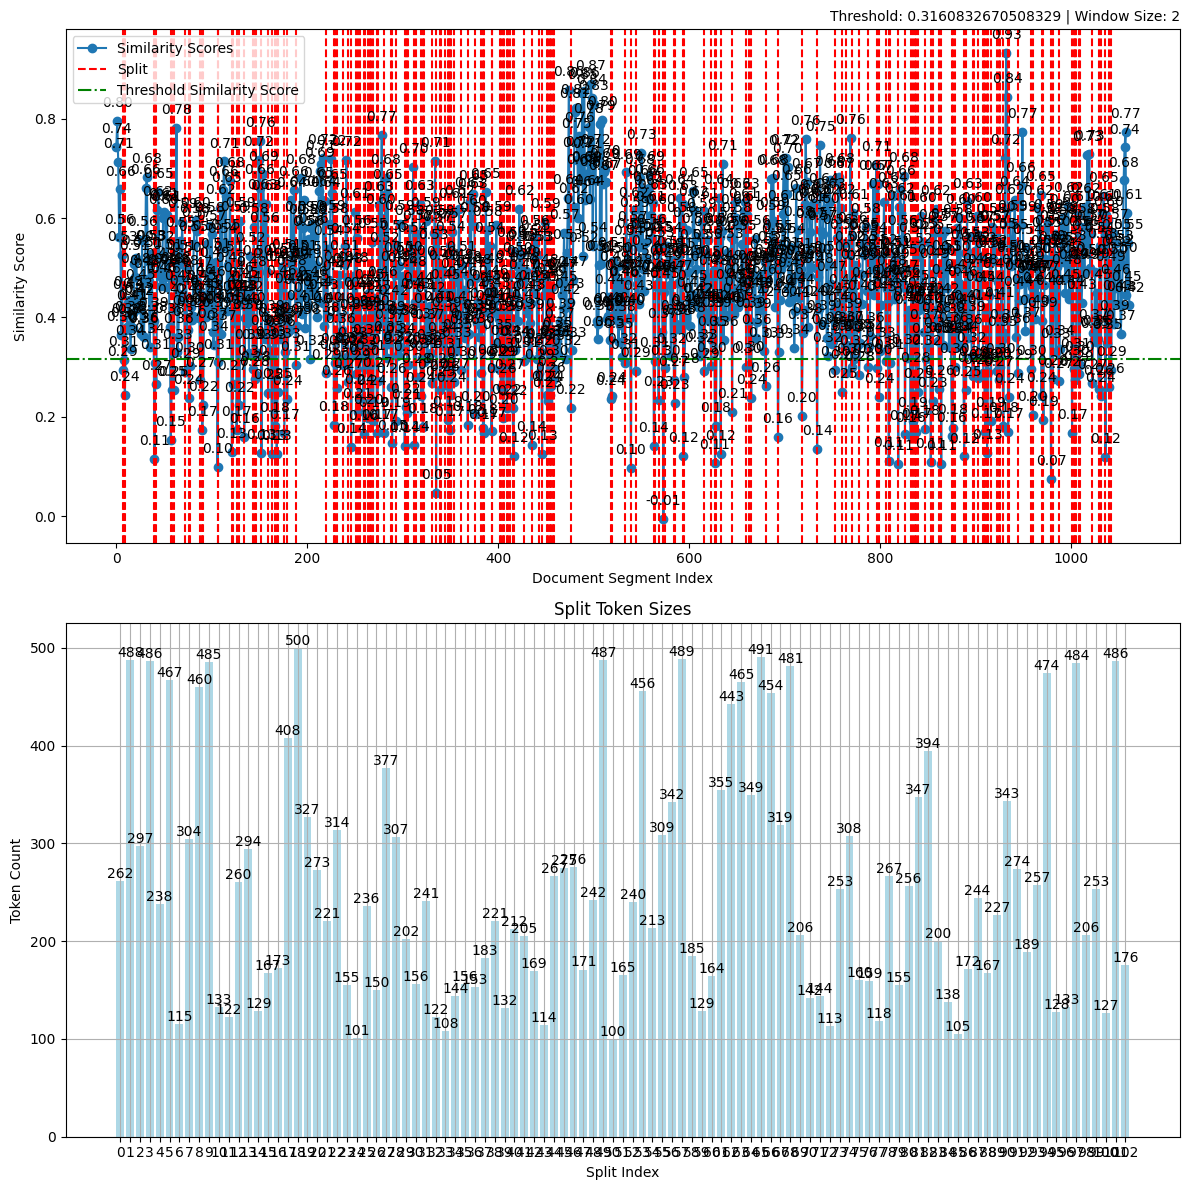

Splitting Statistics:
  - Total Documents: 1063
  - Total Splits: 103
  - Splits by Threshold: 92
  - Splits by Max Chunk Size: 10
  - Last Split: 1
  - Minimum Token Size of Split: 100
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.89


In [3]:
splits = splitter([corpus])

In [16]:
splits[3].docs

['= = Plot = =',
 'The game takes place during the Second Europan War .',
 'Gallian Army Squad 422 , also known as " The Nameless " , are a penal military unit composed of criminals , foreign deserters , and military offenders whose real names are erased from the records and thereon officially referred to by numbers .',
 'Ordered by the Gallian military to perform the most dangerous missions that the Regular Army and Militia will not do , they are nevertheless up to the task , exemplified by their motto , <unk> <unk> , meaning " Always Ready . " The three main characters are No.7 Kurt Irving , an army officer falsely accused of treason who wishes to redeem himself ; Ace No.1 Imca , a female Darcsen heavy weapons specialist who seeks revenge against the Valkyria who destroyed her home ; and No.13 Riela <unk> , a seemingly jinxed young woman who is unknowingly a descendant of the Valkyria .',
 'Together with their fellow squad members , these three are tasked to fight against a mysteriou

In [20]:
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def find_query_despite_whitespace(document, query):

    # Normalize spaces and newlines in the query
    normalized_query = re.sub(r'\s+', ' ', query).strip()
    
    # Create a regex pattern from the normalized query to match any whitespace characters between words
    pattern = r'\s*'.join(re.escape(word) for word in normalized_query.split())
    
    # Compile the regex to ignore case and search for it in the document
    regex = re.compile(pattern, re.IGNORECASE)
    match = regex.search(document)
    
    if match:
        return document[match.start(): match.end()], match.start(), match.end()
    else:
        return None

def harsh_doc_search(document, target):

    if target.endswith('.'):
        target = target[:-1]
    
    if target in document:
        start_index = document.find(target)
        end_index = start_index + len(target)
        return target, start_index, end_index
    else:
        raw_search = find_query_despite_whitespace(document, target)
        if raw_search is not None:
            return raw_search

    # Split the text into sentences
    sentences = re.split(r'[.!?]\s*|\n', document)

    # Find the sentence that matches the query best
    best_match = process.extractOne(target, sentences, scorer=fuzz.token_sort_ratio)

    if best_match[1] < 98:
        return None
    
    reference = best_match[0]

    start_index = document.find(reference)
    end_index = start_index + len(reference)

    return reference, start_index, end_index

In [21]:
extracted_texts = []
for split in splits:
    ref, _, __ = harsh_doc_search(corpus, ' '.join([x for x in split.docs]))
    extracted_texts.append(ref)
    # first_string = split.docs[0]
    # last_string = split.docs[-1]

    # start_index = corpus.index(first_string)
    # end_index = corpus.index(last_string) + len(last_string)

    # extracted_text = corpus[start_index:end_index]
    # extracted_texts.append(extracted_text)

extracted_texts


['= Valkyria Chronicles III = \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers

In [10]:
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [22]:
import numpy as np

# Calculate the number of tokens for each text in extracted_texts
num_tokens = [num_tokens_from_string(text) for text in extracted_texts]

# Calculate and print the mean, median, min, max, and standard deviation of num_tokens
mean_tokens = np.mean(num_tokens)
median_tokens = np.median(num_tokens)
min_tokens = np.min(num_tokens)
max_tokens = np.max(num_tokens)
std_tokens = np.std(num_tokens)

print(f"Mean number of tokens: {mean_tokens}")
print(f"Median number of tokens: {median_tokens}")
print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print(f"Standard deviation of number of tokens: {std_tokens}")


Mean number of tokens: 257.4757281553398
Median number of tokens: 237.0
Minimum number of tokens: 101
Maximum number of tokens: 512
Standard deviation of number of tokens: 121.5115835830401


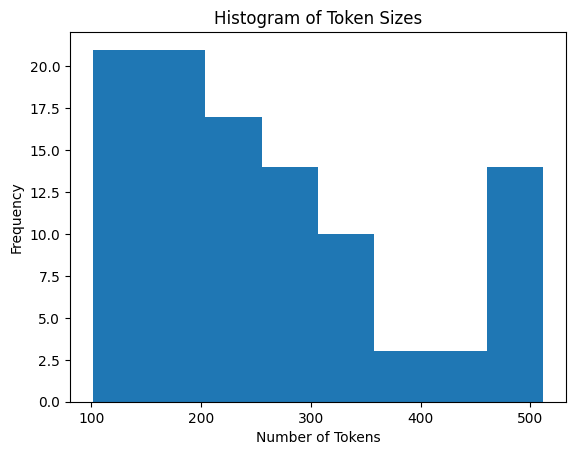

In [23]:
import matplotlib.pyplot as plt

# Create a histogram of token sizes
plt.hist(num_tokens, bins='auto')
plt.title("Histogram of Token Sizes")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


In [24]:
# Find the index of the largest token
index_largest_token = num_tokens.index(max(num_tokens))
print(f"Index of the largest token: {index_largest_token}")


Index of the largest token: 49


In [25]:
splits[index_largest_token].docs

['K.',
 'Westcott ) ; Blackie , 1925',
 'Flower Fairies of the Autumn ; Blackie , 1926',
 'Summer Songs with Music ; Blackie , 1926',
 'The Book of the Flower Fairies ; Blackie , 1927',
 'Autumn Songs with Music ; Blackie , 1927',
 'Old Rhymes for All Times ; Blackie , 1928',
 'The Children ’ s Book of Hymns ; Blackie , 1929 ; rep . 1933',
 'Our Darling ’ s First Book ( written in collaboration with Dorothy Barker ) ; Blackie , 1929',
 'The Little Picture Hymn Book ; Blackie , 1933',
 'Rhymes New and Old ; Blackie , 1933',
 'A Flower Fairy Alphabet ; Blackie , 1934',
 'A Little Book of Old Rhymes ; Blackie , 1936',
 'He Leadeth Me ( written in collaboration with Dorothy Barker ) ; Blackie , 1936',
 'A Little Book of Rhymes New and Old ; Blackie , 1937',
 'The Lord of the Rushie River ; Blackie , 1938',
 'Flower Fairies of the Trees ; Blackie , 1940',
 'When Spring Came In at the Window ; Blackie , 1942',
 'A Child ’ s Garden of Verses ( Robert Louis Stevenson ) ; Blackie , 1944',
 'Flo

In [12]:
print(sum(num_tokens))
print(num_tokens_from_string(corpus))

30987
26649


------ Aurelio Labs -----------

In [3]:
from semantic_router.encoders import OpenAIEncoder
from semantic_chunkers import StatisticalChunker
import os

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

encoder = OpenAIEncoder(name="text-embedding-3-large", openai_api_key=OPENAI_API_KEY)

chunker = StatisticalChunker(encoder=encoder)
chunks = chunker(docs=[corpus])

2024-05-20 17:19:43 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.


In [7]:
chunks[0][0].splits

['= Valkyria Chronicles III =',
 'Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit .',
 'Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable .',
 'Released in January 2011 in Japan , it is the third game in the Valkyria series .',
 'Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .',
 'The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II .']